In [8]:
import pandas as pd
import psycopg2
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import wordcloud
import matplotlib.pyplot as plt

# Download NLTK data files (only need to run once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90023444\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\90023444\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
sql = """
      
SELECT q1.stn_loc_cd as terminal, 
       q1.train_nbr as train,
       q1.actl_dprt_date as date,
       q1.actl_schd_dprt_late_mnt_qty as late,
       q2.delay_mnt_qty as delay,
       q2.nec_rpt_delay_cd as delay_code,
       q2.delay_reason as cause
FROM 
    (SELECT train_nbr, 
            stn_loc_cd, 
            DATE(actl_dprt_dttm) AS actl_dprt_date, 
            actl_dprt_dttm,
            actl_schd_dprt_late_mnt_qty
     FROM a_im_train_perf_station aitps 
     WHERE 
        otp_stn_seq_nbr = 1) AS q1
join 
	(select nec_rpt_train_nbr,
		   delay_mnt_qty,
		   dprt_nec_rpt_intlk_cd,
		   init_trml_actl_dprt_dttm,
		   nec_rpt_delay_cd,
      	   SUBSTRING(delay_note_txt, CHARINDEX('_SPLIT_', delay_note_txt) + LEN('_SPLIT_'), LEN(delay_note_txt) - CHARINDEX('_SPLIT_', delay_note_txt) - LEN('_SPLIT_') + 1) AS delay_reason  	   
FROM edw.f_nec_train_delay 
-- 	where DATE(init_trml_actl_dprt_dttm) = '2024-01-26'
    GROUP BY nec_rpt_train_nbr, delay_mnt_qty, delay_reason, dprt_nec_rpt_intlk_cd,init_trml_actl_dprt_dttm,nec_rpt_delay_cd
) AS q2 ON q1.train_nbr = q2.nec_rpt_train_nbr and q1.stn_loc_cd = q2.dprt_nec_rpt_intlk_cd and q1.actl_dprt_dttm = q2.init_trml_actl_dprt_dttm
where q2.nec_rpt_train_nbr in (52,53)

"""

In [10]:
sql1="""SELECT q1.stn_loc_cd as terminal, 
       q1.train_nbr as train,
       q1.actl_dprt_date as date,
       q1.actl_schd_dprt_late_mnt_qty,
       q2.delay_mnt_qty as delay,
       q2.nec_rpt_delay_cd as delay_code,
       q2.delay_reason as cause
FROM 
    (SELECT train_nbr, 
            stn_loc_cd, 
            DATE(actl_dprt_dttm) AS actl_dprt_date, 
            actl_dprt_dttm,
            actl_schd_dprt_late_mnt_qty
     FROM a_im_train_perf_station aitps 
     WHERE 
--     	DATE(actl_dprt_dttm) = '2024-01-26' AND
        otp_stn_seq_nbr = 1) AS q1
join 
	(select nec_rpt_train_nbr,
		   delay_mnt_qty,
		   dprt_nec_rpt_intlk_cd,
		   init_trml_actl_dprt_dttm,
		   nec_rpt_delay_cd,
      	   SUBSTRING(delay_note_txt, CHARINDEX('_SPLIT_', delay_note_txt) + LEN('_SPLIT_'), LEN(delay_note_txt) - CHARINDEX('_SPLIT_', delay_note_txt) - LEN('_SPLIT_') + 1) AS delay_reason  	   
FROM edw.f_nec_train_delay 
-- 	where DATE(init_trml_actl_dprt_dttm) = '2024-01-26'
    GROUP BY nec_rpt_train_nbr, delay_mnt_qty, delay_reason, dprt_nec_rpt_intlk_cd,init_trml_actl_dprt_dttm,nec_rpt_delay_cd
) AS q2 ON q1.train_nbr = q2.nec_rpt_train_nbr and q1.stn_loc_cd = q2.dprt_nec_rpt_intlk_cd and q1.actl_dprt_dttm = q2.init_trml_actl_dprt_dttm
where q2.nec_rpt_train_nbr in (52,53) and q1.actl_schd_dprt_late_mnt_qty >0 and q2.nec_rpt_delay_cd <> 'NOD'
"""

In [4]:
conn_one=psycopg2.connect("dbname=edwprd host=edwprd.c4606mhizfi6.us-east-1.redshift.amazonaws.com port=5439 user=edw_sagemaker_user password=Am3ric@n#123")

In [5]:
df=pd.read_sql(sql,conn_one)
df1=pd.read_sql(sql1,conn_one)

In [12]:
df

,terminal,train,date,late,delay,delay_code,cause
0,SFA,52,2014-06-27,-9.0,5.0,CTI,S.S. A764.4 TK2;CFRC P323
1,SFA,52,2014-07-06,10.0,10.0,PTI,HOLD FOR PO#98
2,SFA,52,2014-10-31,-11.0,5.0,DSR,25 MPH AT 959-958.5
3,SFA,52,2015-01-04,22.0,22.0,ITI,LATE IB
4,LOR,53,2015-04-25,-33.0,12.0,PTI,AMT 91 XLO
...,...,...,...,...,...,...,...
3847,LOR,53,2024-01-26,-37.0,2.0,NOD,Wait for scheduled departure time
3848,LOR,53,2024-03-02,-9.0,3.0,NOD,Wait for scheduled departure time
3849,LOR,53,2024-03-10,-8.0,8.0,NOD,Wait for scheduled departure time
3850,LOR,53,2024-04-20,78.0,2.0,SYS,"Delay in Block Control Point, Lorton"


In [12]:
def preprocess_text(text):
    # Remove punctuation and digits
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text

# Apply preprocessing to the text column
df1['cleaned_text'] = df1['cause'].apply(preprocess_text)


In [19]:
all_text = ' '.join(df1['cleaned_text'])

wordcloud = WordCloud(width=2500, height=1500, background_color='white').generate(all_text)

# # Display the word cloud using matplotlib
# plt.figure(figsize=(55, 70))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')  # No axes are needed for word cloud
# plt.show()

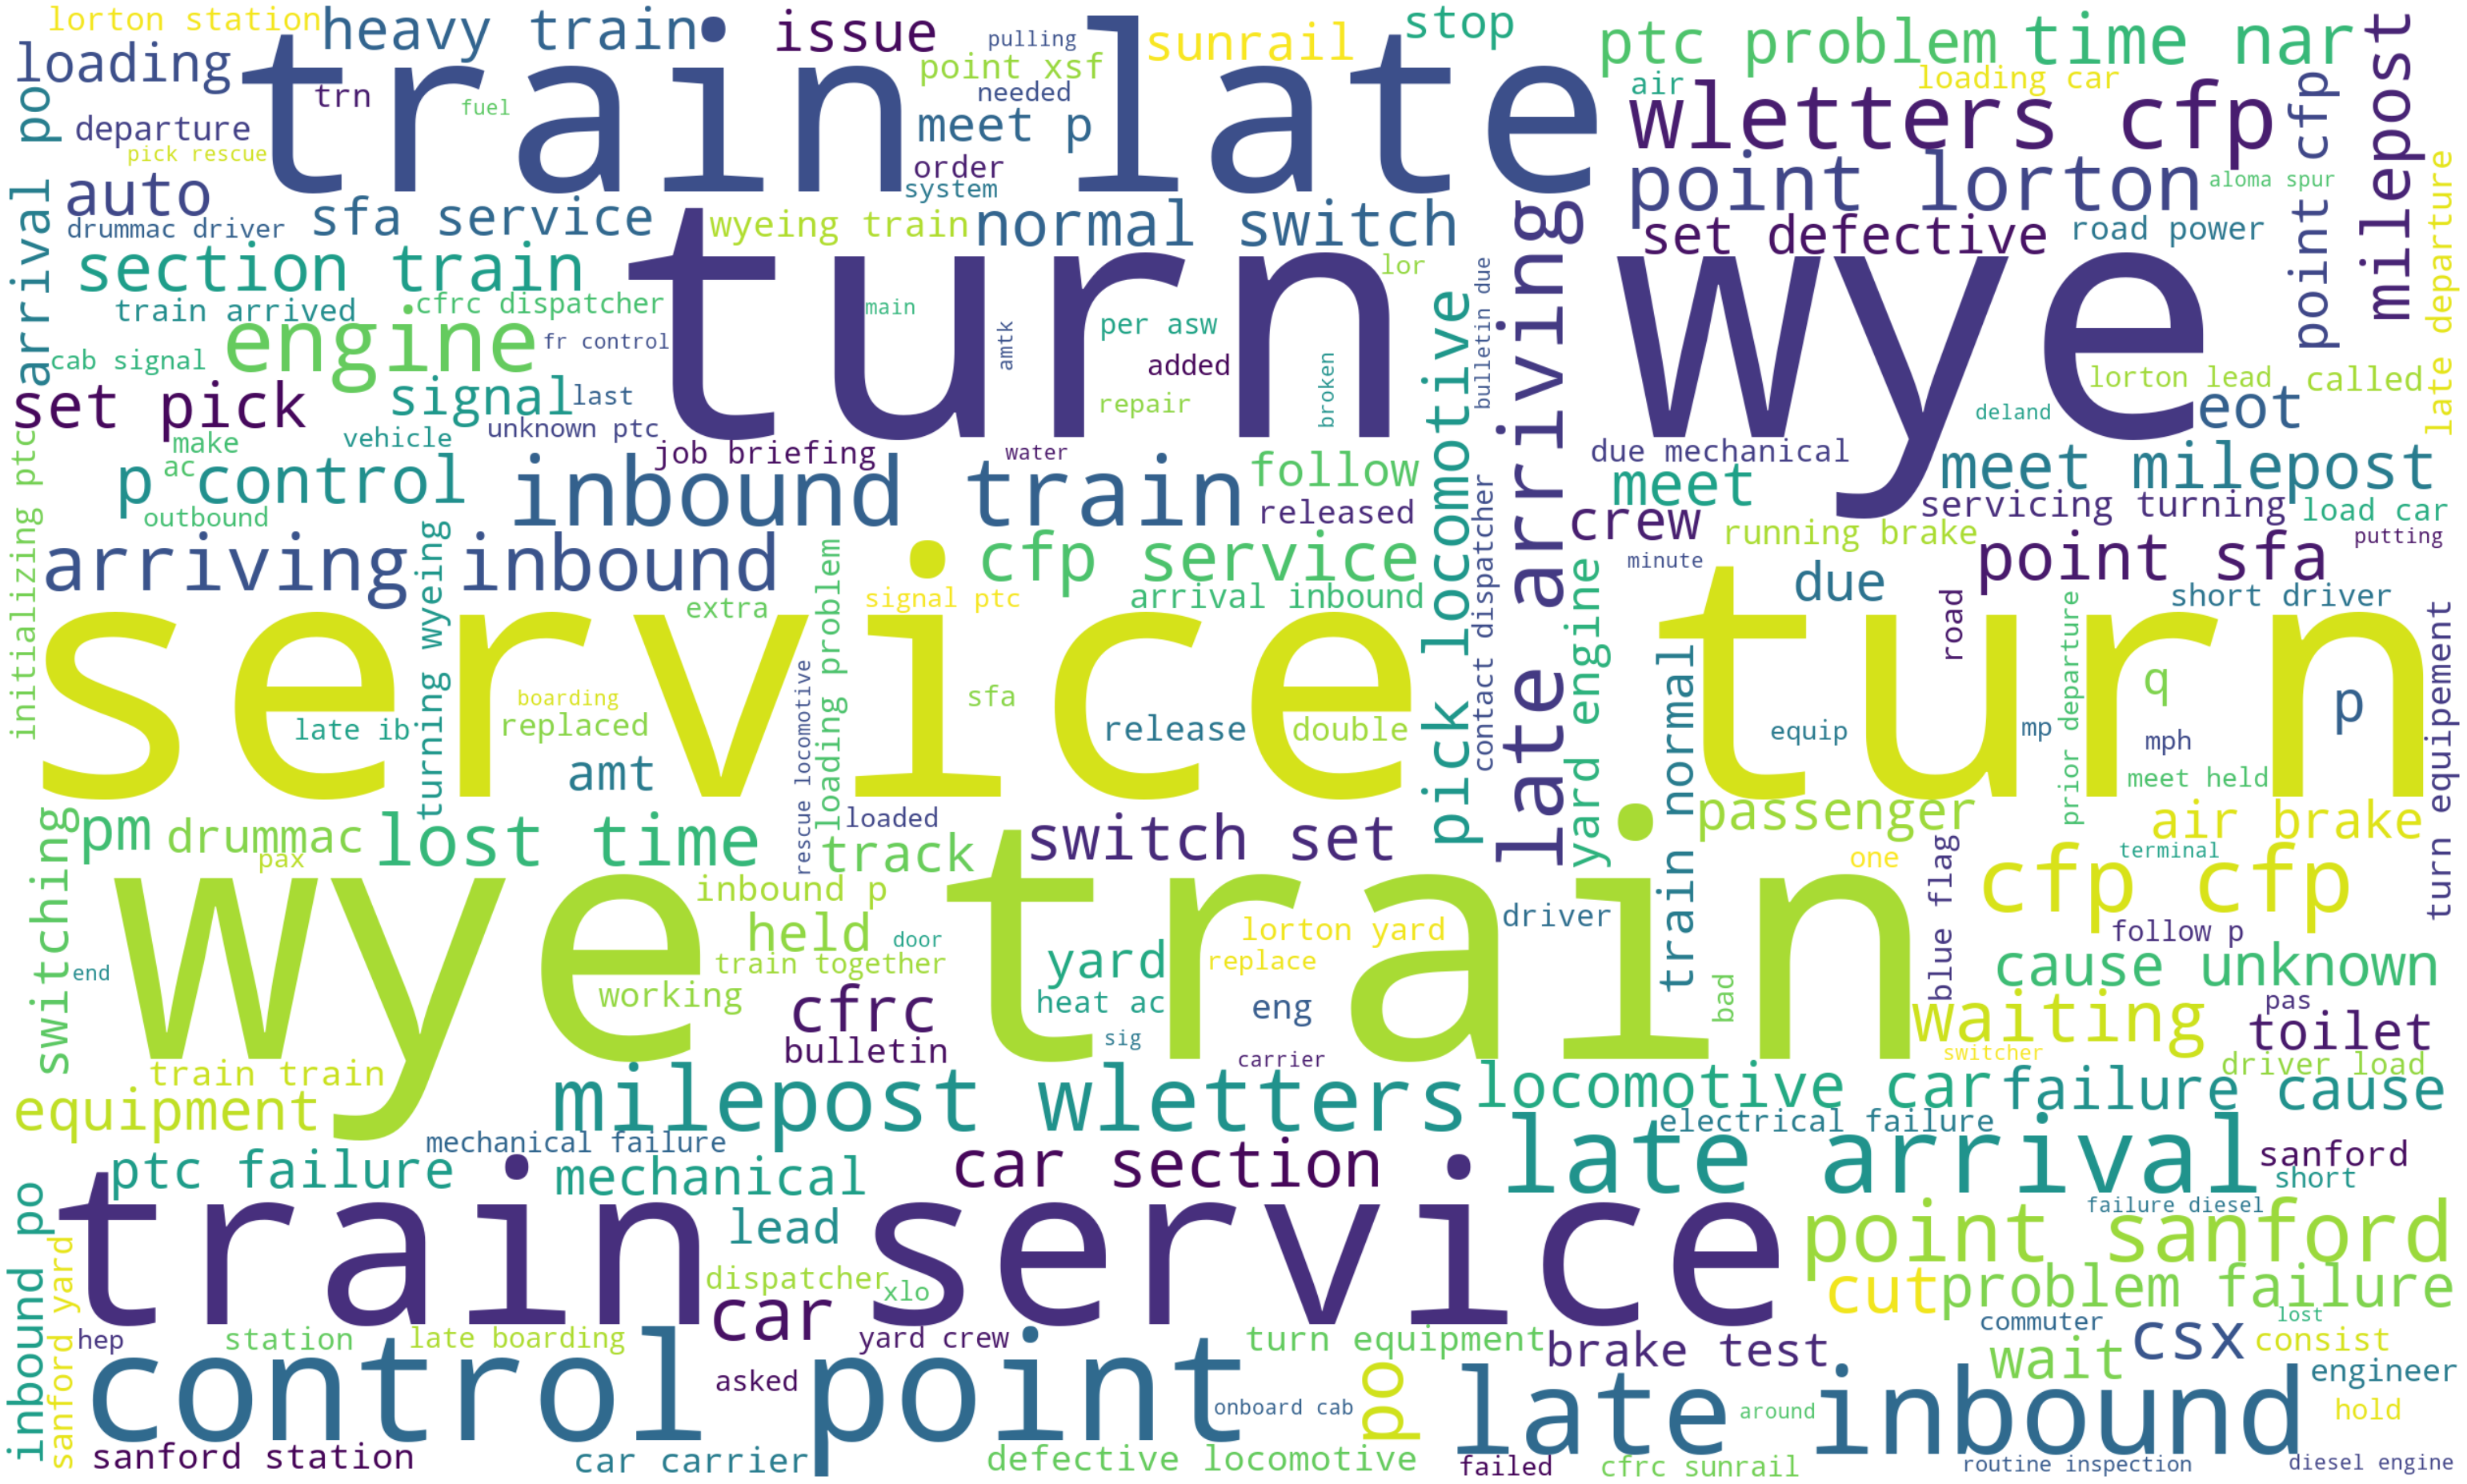

In [18]:
plt.figure(figsize=(55, 70))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes are needed for word cloud
plt.show()

In [21]:
df1.delay_code.value_counts()

ITI    787
SVS    158
ENG    124
OTH    108
SYS     85
PTI     85
CAR     65
CTI     62
FTI     43
DCS     29
RTE     19
WTR     16
DSR     14
DMW      8
POL      6
INJ      6
HLD      3
ADA      3
TRS      2
DTR      1
CCR      1
Name: delay_code, dtype: int64

In [10]:
df.delay_code.value_counts()

NOD    1322
ITI     791
PTI     471
OTH     242
SVS     185
ENG     147
FTI     113
SYS     106
CTI     100
DCS      81
DSR      79
CAR      71
RTE      60
WTR      30
DMW      19
INJ       8
POL       8
HLD       4
TRS       3
ADA       3
MBO       2
DTR       1
CCR       1
Name: delay_code, dtype: int64

In [43]:
df1[df1['delay_code']=='ITI']

,terminal,train,date,actl_schd_dprt_late_mnt_qty,delay,delay_code,cause,cleaned_text
0,SFA,52,2014-07-17,20.0,20.0,ITI,SANFORD;LTE INBND,sanfordlte inbnd
2,SFA,52,2015-12-03,29.0,29.0,ITI,"Service, turn, or wye train 53",service turn wye train
3,SFA,52,2017-07-03,48.0,48.0,ITI,"Service, turn, or wye train 53",service turn wye train
7,LOR,53,2019-04-20,6.0,15.0,ITI,"Service, turn, or wye train 5219",service turn wye train
10,LOR,53,2019-11-10,282.0,282.0,ITI,"Service, turn, or wye train 5209",service turn wye train
...,...,...,...,...,...,...,...,...
1605,SFA,52,2016-12-21,12.0,12.0,ITI,"Service, turn, or wye train 53",service turn wye train
1607,SFA,52,2017-09-22,472.0,472.0,ITI,LATE INBOUND TRAIN LATE ARRIVAL OF PO#53-21 IN...,late inbound train late arrival po sfa terminal
1610,LOR,53,2018-04-16,35.0,35.0,ITI,"Service, turn, or wye train 5215",service turn wye train
1620,SFA,52,2022-12-01,528.0,528.0,ITI,"Service, turn, or wye train 53",service turn wye train


In [10]:
import PIL
print(PIL.__version__)

8.3.2


In [11]:
!pip install --upgrade pillow

Defaulting to user installation because normal site-packages is not writeable
  Using cached Pillow-9.5.0-cp37-cp37m-win_amd64.whl (2.5 MB)


In [7]:
import sys

In [8]:
print(sys.executable)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\python.exe


'which' is not recognized as an internal or external command,
operable program or batch file.
